> The code is provided under AGPL License. You can find out more [here](https://www.gnu.org/licenses/agpl-3.0.en.html).

> All material is licensed under the Creative Commons Attribution-ShareAlike 4.0 International license or newer (CC BY-SA 4.0). 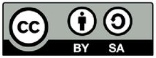

>Errikos Streviniotis, Nikos Giatrakos, Technical University of Crete & Athena RC, 2023 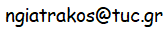

# Acknowledgements
Research Funded by the EU Horizon Europe by the EU project EVENFLOW under Horizon Europe agreement No. 101070430
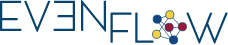



# Install and Import all the necessary packages and libraries

Install the required **tensorflow-io**, **kafka** and **skopt** packages

In [ ]:
!pip install tensorflow-io
!pip install kafka-python
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.6/28.6 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 1.9 MB/s eta 0:00:00


Import packages

In [ ]:
import os
import sys
import random
import math
from datetime import datetime
import time
import threading
import json
from kafka import KafkaProducer, KafkaConsumer
from kafka.errors import KafkaError
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10, cifar100
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer
from tensorflow.python.keras import backend as K
import matplotlib.pyplot as plt

In this notebook we utilize kafka and Bayesian Optimization in order to select the sample rate and the number of epochs given a specific CNN architecture with respect to a score. In particular:


1.   We load our dataset (cifar10, cifar100, mnist, fashion_mnist)
2.   We send our data to the corresponding kafka-topics (both training and testing samples)
3.   We read the data from topics
4.   We employ Bayes_opt in order to select the sampling rate and the number of epochs based on a specific CNN architecture


> NOTE: Our metric is one that captures the tradeoff between the accuracy on the testing set and the training speed of our CNN.
















# Definition of programmer's parameters (Controller's block)

In [ ]:
#@markdown ##Kafka Connector Parameters
kafka_host = "127.0.0.1" # @param
kafka_port = "9092" # @param
topic_prefix = "cifar10" # @param ["cifar10", "cifar100", "mnist", "fashion_mnist"] {type:"string"}
kafka_offset = "earliest" # @param ["earliest", "latest", "none"] {type:"string"}

if topic_prefix == "cifar10":
  dataset = cifar10.load_data()
elif topic_prefix == "cifar100":
  dataset = cifar100.load_data()
elif topic_prefix == "mnist":
  dataset = mnist.load_data()
elif topic_prefix == "fashion_mnist":
  dataset = fashion_mnist.load_data()

#@markdown ##Synopses Tuner Input Configuration
# This variable corresponds to the number of messages that will be sent to kafka,
# and as a result the number of samples that will be used for the training - testing
num_of_training_instances_to_collect = 1000 #@param
num_of_testing_instances_to_collect = 200 #@param
tmp_filter_train = num_of_training_instances_to_collect
tmp_filter_test = num_of_testing_instances_to_collect

#@markdown ##Synopses-based Training Optimization Configuration
# Percentage of the dataset that will be used for training
synopsis_rate_low = 0.05 #@param {type:"slider", min:0, max:0.99, step:0.05}
synopsis_rate_high = 1 #@param {type:"slider", min:0, max:1, step:0.05}
sample_size_low = synopsis_rate_low
sample_size_high = synopsis_rate_high
microbenchmark_budget = 20 #@param {type:"slider", min:1, max:100, step:5}

# Percentage of the dataset that will be used for testing
perc_test = 1 #@@param {type:"number"}

# The ID of the method that will be employed during sampling
# 0: Simple reservoir sampling in our initial training dataset
# 1: Reservoir sampling in each class based on the number of samples (per class)
synopsis_type = "Stratified Reservoir Sampling" # @param ["Reservoir Sampling", "Stratified Reservoir Sampling", "All"]
if synopsis_type == "Reservoir Sampling":
  sampling_method_id = 0
else:
  sampling_method_id = 1

# Function to minimize over the gaussian prior
# It is used in the Bayesian Opt algorithm
acquisition_f = "gp_hedge" #@param ["LCB", "EI", "PI", "gp_hedge"]

# Maximum training time above which we cancel the experiment (in seconds)
# It is used in the score (accuracy--speed tradeoff) formula
max_allowed_latency_in_secs = 5 #@param {type:"integer"}
theta_parameter = max_allowed_latency_in_secs
# Weight for the accuracy of the model. Max value: 0.99
# There is also the weight of training speed of the model (1 - lamda_acc)
# It is used in the score (accuracy--speed tradeoff) formula
accuracy_weight = 0.5 # @param {type:"slider", min:0, max:1, step:0.05}
lamda_acc = accuracy_weight

# Number of epochs for the training process
# One Epoch is when an ENTIRE (training) dataset is passed forward and backward through the neural network only once.
# NOTE: An epoch is comprised of one or more batches.
num_of_epochs_low = 1 #@param {type:"integer"}
num_of_epochs_high = 20 #@param {type:"integer"}

#@markdown ##Neural Network Configuration
##################################################
# CONVOLUTIONAL LAYERS INPUT
##################################################
num_of_conv_layers = 2 #@param {type:"integer"}

##################################################
# POOLING LAYERS INPUT
##################################################
num_of_pool_layers = 2 #@param {type:"integer"}

##################################################
# DENSE LAYERS INPUT
##################################################
num_of_dense_layers = 1 #@param {type:"integer"}

##################################################
# NUMBER OF NEURONS INPUT (seperated by comma)
##################################################
comb_of_neurons_str = '32,64,64' #@param {type:"string"}
list_of_strings = comb_of_neurons_str.split(',')
comb_of_neurons = list(map(int, list_of_strings))




# The size of the batch for the training process
# Total number of training examples present in a single batch.
# or, number of samples processed before the model is updated.
# size_of_batch_low = 10 #@param {type:"integer"}
# size_of_batch_high = 128 #@param {type:"integer"}
size_of_batch = 64 # @param ["32", "64", "128", "256", "512", "1024"] {type:"raw", allow-input: true}

# The value for the learning rate for the training process (it is inserted to the Adam optimizer)
# During the optimization, the algorithm needs to take a series of tiny steps to descend the error mountain in order to minimize the error.
# The direction of the step is determined by the gradient, while the step size is determined by the learning rate.
# lr_low = 1e-4 #@param {type:"number"}
# lr_high = 1e-1 #@param {type:"number"}
learning_rate = 0.001 # @param ["0.001", "0.003", "0.01", "0.03", "0.1", "0.3"] {type:"raw", allow-input: true}
lr = learning_rate

170498071/170498071 [==============================] - 2s 0us/step


# Download and setup **Kafka** and **Zookeeper** instances

In [ ]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.4.1/kafka_2.13-3.4.1.tgz
!tar -xzf kafka_2.13-3.4.1.tgz

In [ ]:
!./kafka_2.13-3.4.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.4.1/config/zookeeper.properties
!./kafka_2.13-3.4.1/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.4.1/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
!ps -ef | grep kafka

root         860       1 16 13:22 ?        00:00:01 java -Xmx512M -Xms512M -server -XX:+UseG1GC -XX:MaxGCPauseMillis=20 -XX:InitiatingHeapOccupancyPercent=35 -XX:+ExplicitGCInvokesConcurrent -XX:MaxInlineLevel=15 -Djava.awt.headless=true -Xlog:gc*:file=/content/kafka_2.13-3.4.1/bin/../logs/zookeeper-gc.log:time,tags:filecount=10,filesize=100M -Dcom.sun.management.jmxremote -Dcom.sun.management.jmxremote.authenticate=false -Dcom.sun.management.jmxremote.ssl=false -Dkafka.logs.dir=/content/kafka_2.13-3.4.1/bin/../logs -Dlog4j.configuration=file:./kafka_2.13-3.4.1/bin/../config/log4j.properties -cp /content/kafka_2.13-3.4.1/bin/../libs/activation-1.1.1.jar:/content/kafka_2.13-3.4.1/bin/../libs/aopalliance-repackaged-2.6.1.jar:/content/kafka_2.13-3.4.1/bin/../libs/argparse4j-0.7.0.jar:/content/kafka_2.13-3.4.1/bin/../libs/audience-annotations-0.13.0.jar:/content/kafka_2.13-3.4.1/bin/../libs/commons-cli-1.4.jar:/content/kafka_2.13-3.4.1/bin/../libs/commons-lang3-3.8.1.jar:/content/kafka_2.1

Create the kafka topics with the following specs:

- train-labels: partitions=1, replication-factor=1
- train-images: partitions=1, replication-factor=1

In [ ]:
import os

os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server "+kafka_host+":"+kafka_port+" --replication-factor 1 --partitions 1 --topic "+topic_prefix+"-train-labels")
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server "+kafka_host+":"+kafka_port+" --replication-factor 1 --partitions 1 --topic "+topic_prefix+"-train-images")
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic train-labels
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic train-images

0

In [ ]:
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server "+kafka_host+":"+kafka_port+" --replication-factor 1 --partitions 1 --topic "+topic_prefix+"-test-labels")
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server "+kafka_host+":"+kafka_port+" --replication-factor 1 --partitions 1 --topic "+topic_prefix+"-test-images")
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic test-labels
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic test-images

0

In [ ]:
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server "+kafka_host+":"+kafka_port+" --topic "+topic_prefix+"-train-labels")
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server "+kafka_host+":"+kafka_port+"  --topic "+topic_prefix+"-train-images")

#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic train-labels
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic train-images

0

In [ ]:
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server "+kafka_host+":"+kafka_port+" --topic "+topic_prefix+"-test-labels")
os.system("./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server "+kafka_host+":"+kafka_port+"  --topic "+topic_prefix+"-test-images")
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic test-labels
#!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic test-images

0

# Load of our Dataset

Upload our dataset and normalize it

In [ ]:
# Load mnist (or fashion_mnist) dataset
(x_train, y_train), (x_test, y_test) = dataset

# Scale images to the [0, 1] range
x_train = x_train / 255
x_test = x_test / 255

if len(x_train.shape) == 3:
  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")


In [ ]:
# The type of input based on the corresponding dataset
dataset_shape = x_train.shape[1:]

# Kafka (send and receive the data)

Send the **training** data (*images* and corresponding *labels*) to kafka appropriate topics

In [ ]:
# Producer part
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, x_tmp, y_tmp):
  producer = KafkaProducer(bootstrap_servers=[kafka_host+":"+kafka_port])
  count = 0
  for (x, y) in zip(x_tmp, y_tmp):
    if topic_name == topic_prefix+'-train-images':
      # Tranform data to bytes
      msg = x.tobytes()
      producer.send(topic_name, msg).add_errback(error_callback)
      producer.flush()
      count += 1
    else:
      yy = np.uint8(y.item())
      str_msg = yy.astype(str)
      # Tranform data to bytes and send to producer
      producer.send(topic_name, bytes(str_msg, 'utf-8')).add_errback(error_callback)
      producer.flush()
      count += 1
    if count >= tmp_filter_train:
      break

  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

# Write to kafka the training images
write_to_kafka(topic_prefix+"-train-images", x_train, y_train)
# Write to kafka the labels of the training images
write_to_kafka(topic_prefix+"-train-labels", x_train, y_train)

Wrote 1000 messages into topic: cifar10-train-images
Wrote 1000 messages into topic: cifar10-train-labels


Send the **testing** data (*images* and corresponding *labels*) to kafka appropriate topics

In [ ]:
def write_to_kafka_test(topic_name, x_tmp, y_tmp):
  producer = KafkaProducer(bootstrap_servers=[kafka_host+":"+kafka_port])
  count = 0
  for (x, y) in zip(x_tmp, y_tmp):
    if topic_name == topic_prefix+'-test-images':
      # Tranform data to bytes
      msg = x.tobytes()
      producer.send(topic_name, msg).add_errback(error_callback)
      producer.flush()
      count += 1
    else:
      yy = np.uint8(y.item())
      str_msg = yy.astype(str)
      # Tranform data to bytes and send to producer
      producer.send(topic_name, bytes(str_msg, 'utf-8')).add_errback(error_callback)
      producer.flush()
      count += 1
    if count >= tmp_filter_test:
      break

  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

# Write to kafka the testing images
write_to_kafka_test(topic_prefix+"-test-images", x_test, y_test)
# Write to kafka the labels of the testing images
write_to_kafka_test(topic_prefix+"-test-labels", x_test, y_test)

Wrote 200 messages into topic: cifar10-test-images
Wrote 200 messages into topic: cifar10-test-labels


De-code the **training** images that were sent to kafka



In [ ]:
# Consumer-part for images
consumer_images = KafkaConsumer(topic_prefix+"-train-images", group_id = 'group1', bootstrap_servers = [kafka_host+":"+kafka_port], auto_offset_reset = kafka_offset)
try:
  tmp_count = 0
  received_images = []
  for message in consumer_images:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    decode_img = np.frombuffer(message.value)
    received_images.append(decode_img)
    del decode_img
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_train:
      break
except KeyboardInterrupt:
    sys.exit()

De-code the **testing** images that were sent to kafka

In [ ]:
# Consumer-part for images
consumer_images_test = KafkaConsumer(topic_prefix+"-test-images", group_id = 'group3', bootstrap_servers = [kafka_host+":"+kafka_port], auto_offset_reset = kafka_offset)
try:
  tmp_count = 0
  received_images_test = []
  for message in consumer_images_test:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    decode_img = np.frombuffer(message.value)
    received_images_test.append(decode_img)
    del decode_img
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_test:
      break
except KeyboardInterrupt:
    sys.exit()

Reshape the received **training** images

In [ ]:
received_images_reshaped = []
for i in range(0, len(received_images)):
  r = received_images[i].reshape(dataset_shape)
  received_images_reshaped.append(r)

Reshape the received **testing** images

In [ ]:
received_images_reshaped_test = []
for i in range(0, len(received_images_test)):
  r = received_images_test[i].reshape(dataset_shape)
  received_images_reshaped_test.append(r)

Receive the **training** labels that were sent to kafka

In [ ]:
consumer_labels = KafkaConsumer(topic_prefix+"-train-labels", group_id = 'group2', bootstrap_servers = [kafka_host+":"+kafka_port], auto_offset_reset = kafka_offset)
try:
  tmp_count = 0
  received_labels = []
  for message in consumer_labels:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    received_labels.append(message.value)
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_train:
      break
except KeyboardInterrupt:
    sys.exit()

Receive the **testing** labels that were sent to kafka

In [ ]:
consumer_labels_test = KafkaConsumer(topic_prefix+"-test-labels", group_id = 'group4', bootstrap_servers = [kafka_host+":"+kafka_port], auto_offset_reset = kafka_offset)
try:
  tmp_count = 0
  received_labels_test = []
  for message in consumer_labels_test:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    received_labels_test.append(message.value)
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_test:
      break
except KeyboardInterrupt:
    sys.exit()

Decode the received **training** labels

In [ ]:
received_labels_decoded = []
for i in range(0, len(received_labels)):
  l = int(received_labels[i].decode("utf-8"))
  received_labels_decoded.append(l)

Decode the received **testing** labels

In [ ]:
received_labels_decoded_test = []
for i in range(0, len(received_labels_test)):
  l = int(received_labels_test[i].decode("utf-8"))
  received_labels_decoded_test.append(l)

Verify that everything performs as it should... by checking the exact number of received images and labels...

In [ ]:
print("Received Training Data:")
print("------> # of received images:", len(received_images_reshaped))
print("------> # of received labels:", len(received_labels_decoded))

Received Training Data:
------> # of received images: 1000
------> # of received labels: 1000


In [ ]:
print("Received Testing Data:")
print("------> # of received images:", len(received_images_reshaped_test))
print("------> # of received labels:", len(received_labels_decoded_test))

Received Testing Data:
------> # of received images: 200
------> # of received labels: 200


# Synopsis block of code

In [ ]:
# Get unique labels in our (received) training dataset
unique_class_labels = np.unique(received_labels_decoded)

In [ ]:
# A function that prints the occurence of each class in a list
def print_times_per_label(lst, labels_all):
  # Get unique labels in our training dataset
  unique_labels = np.unique(labels_all)
  for i in range(0, len(unique_labels)):
    print("Class", unique_labels[i], "has", lst.count(i), "samples in our dataset...")

In [ ]:
# Select k items from a stream of items-data

# A function to randomly select k items from stream[0..n-1].
def reservoir_sampling(stream, n, k):
  i = 0     # index for elements in stream[]

  # reservoir[] is the output array.
  # Initialize it with first k elements from stream[]
  reservoir = [0] * k

  for i in range(k):
    reservoir[i] = stream[i]

  # Iterate from the (k+1)th element to Nth element
  while(i < n):
    # Pick a random index from 0 to i.
    j = random.randrange(i+1)

    # If the randomly picked
    # index is smaller than k,
    # then replace the element
    # present at the index
    # with new element from stream
    if(j < k):
      reservoir[j] = stream[i]
    i+=1

  return reservoir

In [ ]:
# A function that finds the size of each reservoir for every class depending on its occurence in the initial dataset
# and returns the unique labels that exist in our dataset along with the corresponding percentage
def reservoir_size_per_class(init_labels):

  # Get unique labels and their counts (how many times they appear) in our training dataset
  unique_labels, counts = np.unique(init_labels, return_counts = True)

  # Transform to list
  unique_labels_lst = unique_labels.tolist()
  counts_lst = counts.tolist()

  perc_per_class = []
  for i in range(len(unique_labels_lst)):
    perc_per_class.append(counts_lst[i]/len(init_labels))

  # print(perc_per_class)

  return perc_per_class, unique_labels_lst

Sampling - part (for the received data, i.e., received images and labels **only**)

In [ ]:
def sampling_method(sampling_method_id, received_images_reshaped, received_labels_decoded, sample_size):
  print("Percentage of filtering in our training dataset was set:")
  print(sample_size)

  if sampling_method_id == 0:
    # Simple reservoir sampling over the whole training dataset
    # Total size of the stream (or training dataset)
    n_train = len(received_images_reshaped)

    # Number of samples that will be drawn
    k_train = int(n_train * sample_size)

    # Use the indexes of dataset in order to decide which samples will be drawn
    idx_tmp_train_list = list(range(0, n_train))

    # Find the indexes in order to construct the dataset that will be used during the training process
    idx_train = reservoir_sampling(idx_tmp_train_list, n_train, k_train)
  else:
    # Reservoir sampling in each class based on the number of samples (per class) that exist in the initial dataset
    # Find the size of each reservoir for every class depending on its occurence in the initial training dataset
    class_perc, unique_ids = reservoir_size_per_class(received_labels_decoded)
    print(class_perc)
    # Stores the indexes (from all classes) in order to construct the dataset that will be used during the training process
    idx_train = []

    # Run for every single class the reservoir sampling seperately
    for i in range(0, len(unique_ids)):
      # Find the locations of each sample belonging to our class of interest
      tmp = np.where(np.asarray(received_labels_decoded) == unique_ids[i])
      idx_of_class = tmp[0].tolist()

      # Run the reservoir sampling for the class of interest
      sampled_idx_of_class = reservoir_sampling(idx_of_class, len(idx_of_class), int(len(received_images_reshaped) * sample_size * class_perc[i]))

      # Store the (sampled) samples from this class
      for j in range(0, len(sampled_idx_of_class)):
        idx_train.append(sampled_idx_of_class[j])

  # Store the corresponding images and labels from training dataset based on the sampled indexes
  train_images_lst = []
  for i in idx_train:
    train_images_lst.append(received_images_reshaped[i])

  train_labels_lst = []
  for i in idx_train:
    train_labels_lst.append(received_labels_decoded[i])

  # Check the occurence of each class in the final training dataset
  print_times_per_label(train_labels_lst, received_labels_decoded)

  # Tranfsorm the lists that we stored our samples into arrays
  train_images = np.asarray(train_images_lst)
  train_labels = np.asarray(train_labels_lst)

  # Verify that the desired filtering was performed in both datasets
  print("Training dataset before sampling:")
  print(len(received_images_reshaped))
  print(len(received_labels_decoded))
  print("Training dataset after sampling:")
  print(train_images.shape)
  print(train_labels.shape)

  return train_images, train_labels

# CNN's architecture builder

Function that creates and returns a specific model, i.e., CNN architecture

In [ ]:
def create_model():
    model = models.Sequential()

    ############################################################################################
    # Part I: Convolutional part of our network, i.e., extraction of (important) features
    ############################################################################################
    if num_of_conv_layers > num_of_pool_layers:
      for i in range(0, int(num_of_conv_layers) - int(num_of_pool_layers)):
        if i == 0:
          model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu', input_shape = dataset_shape))
        else:
          model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu'))

      for i in range(int(num_of_conv_layers) - int(num_of_pool_layers), int(num_of_conv_layers)):
        model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))

    elif num_of_conv_layers == num_of_pool_layers:
      for i in range(0, int(num_of_conv_layers)):
        if i == 0:
          model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu', input_shape = dataset_shape))
          model.add(layers.MaxPooling2D((2, 2)))
        else:
          model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu'))
          model.add(layers.MaxPooling2D((2, 2)))
    else:
      for i in range(0, int(num_of_conv_layers)):
        if i == 0:
          model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu', input_shape = dataset_shape))
          model.add(layers.MaxPooling2D((2, 2)))
        else:
          model.add(layers.Conv2D(comb_of_neurons[i], (3, 3), activation='relu'))
          model.add(layers.MaxPooling2D((2, 2)))

      for i in range(int(num_of_conv_layers), int(num_of_pool_layers)):
        model.add(layers.MaxPooling2D((2, 2)))



    ############################################################################################
    # Part II: Dense part of our network, i.e., classification of an image in our classes
    ############################################################################################

    # Converts multi-dimensional matrix to single dimensional matrix.
    model.add(layers.Flatten())

    # Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer
    for i in range(0, int(num_of_dense_layers)):
      model.add(layers.Dense(comb_of_neurons[int(num_of_conv_layers) + i], activation='relu'))

    # Softmax is an activation function that is used mainly for classification tasks
    # It normalizes the input vector into a probability distribution  that is proportional to the exponential of the input numbers.
    model.add(layers.Dense(len(unique_class_labels), activation='softmax'))

    model.compile(optimizer=Adam(lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    return model

# Bayesian Optimizer (using GPR)

Definition of the **search space** of our optimizer

In [ ]:
dim_sample_size = Real(low=sample_size_low, high=sample_size_high, name='sample_size')
# dim_learning_rate = Real(low=lr_low, high=lr_high, prior='log-uniform', name='learning_rate')
# dim_batch_size = Integer(low=size_of_batch_low, high=size_of_batch_high, name='batch_size')
dim_epochs_number = Integer(low=num_of_epochs_low, high=num_of_epochs_high, name='epochs_number')
#dim_adam_decay = Real(low=1e-6,high=1e-2,name="adam_decay")
#dim_activation = Categorical(categories=['relu', 'sigmoid'], name='activation')

dimensions = [dim_sample_size,
              dim_epochs_number
             ]

default_parameters = [0.2, 3]

Our "black-box" function. The function that we want to *minimize*. It contains the sampling and the learning model. It evaluates our model with respect to the accuracy, training time and the score, i.e, the metric that captures the tradeoff between accuracy and training speed.

In [ ]:
@use_named_args(dimensions = dimensions)
def fitness(sample_size, epochs_number):

    # Call the sampling method
    train_images, train_labels = sampling_method(sampling_method_id, received_images_reshaped, received_labels_decoded, sample_size)

    # Function that creates the model
    model = create_model()

    model.summary()

    start = time.time()

    blackbox = model.fit(x=train_images,
                        y=train_labels,
                        epochs=epochs_number,
                        batch_size=size_of_batch
                        )
    stop = time.time()

    # Compute the training speed of this CNN architecture
    tr_time = stop - start

    # Transform to numpy arrays
    received_images_reshaped_test_arr = np.asarray(received_images_reshaped_test)
    received_labels_decoded_test_arr = np.asarray(received_labels_decoded_test)

    # Evaluate our model on the test dataset
    test_loss, test_acc = model.evaluate(received_images_reshaped_test_arr, received_labels_decoded_test_arr)

    # # Return the validation accuracy for the last epoch.
    # accuracy = blackbox.history['val_accuracy'][-1]

    # Compute the metric that captures the accuracy--speed tradeoff
    tradeOff_metric = lamda_acc * test_acc - (1 - lamda_acc) * math.tanh(tr_time/theta_parameter - 1)

    # Print the results.
    print()
    print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
    print(f"Training time: ", tr_time)
    print(tradeOff_metric)
    print()

    # Store the accuracy and the training speed of the corresponding model in order to be printed in the final cell
    tmp = [test_acc, tr_time]
    extra_results.append(tmp)

    # Delete the Keras model with these hyper-parameters from memory.
    del model

    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    tf.compat.v1.reset_default_graph()

    return -tradeOff_metric

In [ ]:
K.clear_session()
tf.compat.v1.reset_default_graph()

In [ ]:
global extra_results
extra_results = []

Bayesian optimization using Gaussian Processes

In [ ]:
gp_result = gp_minimize(func=fitness,
                            dimensions = dimensions,
                            n_calls = microbenchmark_budget,
                            acq_func = acquisition_f,
                            noise = "gaussian",
                            n_jobs = -1,
                            x0 = default_parameters)

Percentage of filtering in our training dataset was set:
0.2
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 20 samples in our dataset...
Class 1 has 22 samples in our dataset...
Class 2 has 19 samples in our dataset...
Class 3 has 18 samples in our dataset...
Class 4 has 19 samples in our dataset...
Class 5 has 17 samples in our dataset...
Class 6 has 21 samples in our dataset...
Class 7 has 20 samples in our dataset...
Class 8 has 19 samples in our dataset...
Class 9 has 20 samples in our dataset...
Training dataset before sampling:
1000
1000
Training dataset after sampling:
(195, 32, 32, 3)
(195,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )     

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 11s 51ms/step - loss: 2.3121 - accuracy: 0.0974
Epoch 2/3
4/4 [==============================] - 0s 5ms/step - loss: 2.2781 - accuracy: 0.1077
Epoch 3/3
7/7 [==============================] - 0s 20ms/step - loss: 2.2685 - accuracy: 0.1350

Accuracy (on the testing dataset): 13.50%
Training time:  21.601737022399902
-0.4311955816154648

Percentage of filtering in our training dataset was set:
0.2488370269018083
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 25 samples in our dataset...
Class 1 has 27 samples in our dataset...
Class 2 has 24 samples in our dataset...
Class 3 has 22 samples in our dataset...
Class 4 has 24 samples in our dataset...
Class 5 has 21 samples in our dataset...
Class 6 has 26 samples in our dataset...
Class 7 has 25 samples in our dataset...
Class 8 has 24 samples in our dataset...
Class 9 has 25 samples in our dataset...
Training dataset before sampling:
1000
1000
Training dataset after

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 2s 47ms/step - loss: 2.3226 - accuracy: 0.0922
Epoch 2/20
5/5 [==============================] - 0s 7ms/step - loss: 2.2788 - accuracy: 0.1560
Epoch 3/20
5/5 [==============================] - 0s 6ms/step - loss: 2.2495 - accuracy: 0.1525
Epoch 4/20
5/5 [==============================] - 0s 6ms/step - loss: 2.2049 - accuracy: 0.2447
Epoch 5/20
5/5 [==============================] - 0s 5ms/step - loss: 2.1461 - accuracy: 0.2660
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 2.0757 - accuracy: 0.3369
Epoch 7/20
5/5 [==============================] - 0s 5ms/step - loss: 2.0426 - accuracy: 0.2695
Epoch 8/20
5/5 [==============================] - 0s 5ms/step - loss: 1.9356 - accuracy: 0.2943
Epoch 9/20
5/5 [==============================] - 0s 5ms/step - loss: 1.9350 - accuracy: 0.2943
Epoch 10/20
5/5 [==============================] - 0s 5ms/step - loss: 1.8586 - accuracy: 0.3546
Epoch 11/20
5/5 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


6/6 [==============================] - 2s 39ms/step - loss: 2.3157 - accuracy: 0.0822
Epoch 2/15
6/6 [==============================] - 0s 8ms/step - loss: 2.2718 - accuracy: 0.1562
Epoch 3/15
6/6 [==============================] - 0s 5ms/step - loss: 2.2144 - accuracy: 0.1726
Epoch 4/15
6/6 [==============================] - 0s 5ms/step - loss: 2.1468 - accuracy: 0.1973
Epoch 5/15
6/6 [==============================] - 0s 5ms/step - loss: 2.0566 - accuracy: 0.2493
Epoch 6/15
6/6 [==============================] - 0s 5ms/step - loss: 1.9590 - accuracy: 0.2822
Epoch 7/15
6/6 [==============================] - 0s 6ms/step - loss: 1.8904 - accuracy: 0.3205
Epoch 8/15
6/6 [==============================] - 0s 5ms/step - loss: 1.7809 - accuracy: 0.4438
Epoch 9/15
6/6 [==============================] - 0s 5ms/step - loss: 1.6842 - accuracy: 0.4740
Epoch 10/15
6/6 [==============================] - 0s 5ms/step - loss: 1.5744 - accuracy: 0.5233
Epoch 11/15
6/6 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 0s 4ms/step - loss: 2.2742 - accuracy: 0.1700

Accuracy (on the testing dataset): 17.00%
Training time:  3.5940239429473877
0.22200545827804533

Percentage of filtering in our training dataset was set:
0.43513354019012657
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 44 samples in our dataset...
Class 1 has 48 samples in our dataset...
Class 2 has 43 samples in our dataset...
Class 3 has 40 samples in our dataset...
Class 4 has 43 samples in our dataset...
Class 5 has 36 samples in our dataset...
Class 6 has 46 samples in our dataset...
Class 7 has 44 samples in our dataset...
Class 8 has 43 samples in our dataset...
Class 9 has 44 samples in our dataset...
Training dataset before sampling:
1000
1000
Training dataset after sampling:
(431, 32, 32, 3)
(431,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 2s 31ms/step - loss: 2.3070 - accuracy: 0.0858
Epoch 2/3
7/7 [==============================] - 0s 5ms/step - loss: 2.2606 - accuracy: 0.1833
Epoch 3/3
7/7 [==============================] - 0s 3ms/step - loss: 2.2084 - accuracy: 0.1800

Accuracy (on the testing dataset): 18.00%
Training time:  1.8167154788970947
0.3713094930731392

Percentage of filtering in our training dataset was set:
0.417271154470322
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 42 samples in our dataset...
Class 1 has 46 samples in our dataset...
Class 2 has 41 samples in our dataset...
Class 3 has 38 samples in our dataset...
Class 4 has 41 samples in our dataset...
Class 5 has 35 samples in our dataset...
Class 6 has 44 samples in our dataset...
Class 7 has 42 samples in our dataset...
Class 8 has 41 samples in our dataset...
Class 9 has 42 samples in our dataset...
Training dataset before sampling:
1000
1000
Training dataset after sam

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 [==============================] - 0s 3ms/step - loss: 2.2908 - accuracy: 0.1300

Accuracy (on the testing dataset): 13.00%
Training time:  2.016240358352661
0.33236713803563506

Percentage of filtering in our training dataset was set:
0.4714477387569558
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 48 samples in our dataset...
Class 1 has 52 samples in our dataset...
Class 2 has 46 samples in our dataset...
Class 3 has 43 samples in our dataset...
Class 4 has 46 samples in our dataset...
Class 5 has 40 samples in our dataset...
Class 6 has 50 samples in our dataset...
Class 7 has 48 samples in our dataset...
Class 8 has 46 samples in our dataset...
Class 9 has 48 samples in our dataset...
Training dataset before sampling:
1000
1000
Training dataset after sampling:
(467, 32, 32, 3)
(467,)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 2s 24ms/step - loss: 2.2941 - accuracy: 0.1113
Epoch 2/15
8/8 [==============================] - 0s 5ms/step - loss: 2.2081 - accuracy: 0.2206
Epoch 3/15
8/8 [==============================] - 0s 4ms/step - loss: 2.1029 - accuracy: 0.2484
Epoch 4/15
8/8 [==============================] - 0s 5ms/step - loss: 1.9925 - accuracy: 0.2719
Epoch 5/15
8/8 [==============================] - 0s 6ms/step - loss: 1.8821 - accuracy: 0.3276
Epoch 6/15
8/8 [==============================] - 0s 5ms/step - loss: 1.8297 - accuracy: 0.3619
Epoch 7/15
8/8 [==============================] - 0s 5ms/step - loss: 1.7663 - accuracy: 0.3854
Epoch 8/15
8/8 [==============================] - 0s 4ms/step - loss: 1.6519 - accuracy: 0.4325
Epoch 9/15
8/8 [==============================] - 0s 5ms/step - loss: 1.5920 - accuracy: 0.4582
Epoch 10/15
8/8 [==============================] - 0s 4ms/step - loss: 1.5572 - accuracy: 0.4390
Epoch 11/15
8/8 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


8/8 [==============================] - 2s 5ms/step - loss: 2.3090 - accuracy: 0.0938
Epoch 2/2
7/7 [==============================] - 0s 4ms/step - loss: 2.2575 - accuracy: 0.1250

Accuracy (on the testing dataset): 12.50%
Training time:  2.000540018081665
0.3309863547843442

Percentage of filtering in our training dataset was set:
0.628910618194052
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 64 samples in our dataset...
Class 1 has 70 samples in our dataset...
Class 2 has 62 samples in our dataset...
Class 3 has 57 samples in our dataset...
Class 4 has 62 samples in our dataset...
Class 5 has 53 samples in our dataset...
Class 6 has 67 samples in our dataset...
Class 7 has 64 samples in our dataset...
Class 8 has 62 samples in our dataset...
Class 9 has 64 samples in our dataset...
Training dataset before sampling:
1000
1000
Training dataset after sampling:
(625, 32, 32, 3)
(625,)
Model: "sequential"
______________________________________________

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 2s 23ms/step - loss: 2.3054 - accuracy: 0.1120
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 2.2265 - accuracy: 0.2224
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 2.1023 - accuracy: 0.2624
Epoch 4/5
10/10 [==============================] - 0s 4ms/step - loss: 1.9634 - accuracy: 0.3120
Epoch 5/5
7/7 [==============================] - 0s 3ms/step - loss: 1.9149 - accuracy: 0.3300

Accuracy (on the testing dataset): 33.00%
Training time:  2.0419135093688965
0.4305289008339

Percentage of filtering in our training dataset was set:
0.6382595836302476
[0.102, 0.112, 0.099, 0.092, 0.099, 0.085, 0.107, 0.102, 0.099, 0.103]
Class 0 has 65 samples in our dataset...
Class 1 has 71 samples in our dataset...
Class 2 has 63 samples in our dataset...
Class 3 has 58 samples in our dataset...
Class 4 has 63 samples in our dataset...
Class 5 has 54 samples in our dataset...
Class 6 has 68 samples in our dataset.

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


10/10 [==============================] - 2s 24ms/step - loss: 2.3174 - accuracy: 0.1055
Epoch 2/7
10/10 [==============================] - 0s 5ms/step - loss: 2.2614 - accuracy: 0.1386
Epoch 3/7
10/10 [==============================] - 0s 4ms/step - loss: 2.1740 - accuracy: 0.2031
Epoch 4/7
10/10 [==============================] - 0s 4ms/step - loss: 2.0274 - accuracy: 0.2961
Epoch 5/7
10/10 [==============================] - 0s 5ms/step - loss: 1.8858 - accuracy: 0.3465
Epoch 6/7
10/10 [==============================] - 0s 4ms/step - loss: 1.7830 - accuracy: 0.3496
Epoch 7/7
7/7 [==============================] - 0s 3ms/step - loss: 1.8448 - accuracy: 0.3700

Accuracy (on the testing dataset): 37.00%
Training time:  3.2991905212402344
0.34881096286558033



Results of Bayes Opt algorithm

In [ ]:
print("Best combination was", gp_result.x ,"and the achieved score was -------->   " + str(round(gp_result.fun*-1,2)))

Best combination was [0.628910618194052, 5] and the achieved score was -------->   0.43


Inshights of BayesOpt algorithm in each iteration (or call)

In [ ]:
df_extra = pd.DataFrame(extra_results, columns = ["Accuracy", "Training Speed (sec)"])

pd_tmp = pd.concat([pd.DataFrame(gp_result.x_iters, columns = ["Sample Size", "Epochs"]),
(pd.Series(gp_result.func_vals*-1, name="Score (Tradeoff accuracy--speed)"))], axis=1)

pd.concat([pd_tmp, df_extra], axis=1)

,Sample Size,Epochs,Score (Tradeoff accuracy--speed),Accuracy,Training Speed (sec)
0,0.200000,3,-0.431196,0.135,21.601737
1,0.248837,1,0.179325,0.145,3.915039
2,0.848668,2,0.158424,0.265,4.740526
3,0.055703,18,-0.080971,0.150,6.613474
4,0.685710,9,0.325689,0.325,3.306154
5,0.363711,12,0.410634,0.315,2.211505
6,0.254439,18,0.298251,0.265,3.277426
7,0.923343,19,0.304767,0.425,4.066642
8,0.149526,1,0.311746,0.085,1.989851
9,0.393872,19,0.361232,0.320,2.867071


import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_0, *['Sample Size'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_1, *['Epochs'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_2, *['Score (Tradeoff accuracy--speed)'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(_df_3, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_4, *['Sample Size'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_5, *['Epochs'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_6, *['Score (Tradeoff accuracy--speed)'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(_df_7, *['Accuracy'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(_df_8, *[[['Sample Size', 'Epochs'], ['Epochs', 'Score (Tradeoff accuracy--speed)'], ['Score (Tradeoff accuracy--speed)', 'Accuracy'], ['Accuracy', 'Training Speed (sec)']]], **{})
chart